In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import logging
import os
import pickle
import json
import model_graphics
import dojolib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from xgboost import XGBRegressor
from collections import defaultdict
from datastore import DataStore
from settings import(
    RISK_CLASS_GT,
    FEATURES_FILE_CLASS_GT,
    CVE2META_PICKLE_FP,
    JSON_USERS_TO_EMAIL,
)

In [3]:
# logging.basicConfig(level=logging.DEBUG)
# root_logger = logging.getLogger()
# root_logger.setLevel(logging.DEBUG)

# matplotlib_logger = logging.getLogger("matplotlib")
# matplotlib_logger.setLevel(logging.WARNING)

### Loading and Filtering Data for Modeling
The script begins by loading all necessary data, including feature vectors, user risk assessments, and helper mappings (e.g., user IDs to emails). These datasets are read from pickle and JSON files.

Next, it identifies all unique users in both the classification and numerical datasets. To ensure data quality, users with placeholder or irrelevant emails (e.g., ignored.com, admin@defectdojo.local) are filtered out.

Finally, the script converts user IDs into real email addresses and filters the votes accordingly, preparing the data for personalized modeling and analysis.


In [ ]:
english = False
current_dir = os.getcwd()

with open(RISK_CLASS_GT, 'rb') as f:
    class_votes = pickle.load(f)

with open(JSON_USERS_TO_EMAIL, 'r') as f:
    users_to_email = json.load(f)

class_users = set(item["user_id"] for item in class_votes)
class_users = {user_id for user_id in class_users if users_to_email["crivo_dev"][str(user_id)] not in ["ignored.com", "admin@defectdojo.local"]}
class_users_real_name = set(users_to_email["crivo_dev"][str(user_id)] for user_id in class_users)
class_votes_filtered = [item for item in class_votes if item["user_id"] in class_users]

In [5]:
rename_users_class = {
    'franciscoaragao785@gmail.com' : 'Francisco',
    'italocunha@gmail.com' : 'Italo',
    'bernnardosbo@gmail.com' : 'Bernnardo',
    'leonardooliveiramaia1gmail.com' : 'Leonardo',
    'isrios89@gmail.com' : 'Iago',
    'thbragasouza@gmail.com' : 'Thiago',
    'matheus.gimpel@gmail.com' : 'Matheus'
}

In [6]:
ds = DataStore()
ds.load(metadata_fp=CVE2META_PICKLE_FP)

### Personalized Model Training for Each User

Each user is assigned a personalized regression model trained on their own data. After merging feature and ranking data, rows with missing rankings are removed. For each user with available data, irrelevant columns are dropped, and a simple XGBoost model is trained to predict their rankings. This tailored approach helps capture individual user behavior more accurately than a one-size-fits-all model.

In [ ]:
class_features, class_rankings = dojolib.load_features_rankings(
    FEATURES_FILE_CLASS_GT, RISK_CLASS_GT, ds
)
class_df = dojolib.get_merged_df(class_features, class_rankings)

# remove rows with NaN in 'ranking' column
class_df = class_df.dropna(subset=["ranking"])
user2model = {}
user2predictions = {}
user2truevotes = {}
user2in_kev = defaultdict(list)
for user in class_users_real_name:
    user_rows = class_df[class_df["email"] == user].copy()
    if user_rows.empty:
        logging.warning(f"No data for user {user}, skipping.")
        continue
    # remove unnecessary columns
    user_rows = user_rows.drop(columns=["email", "user_id", "fid", "id"])
    # train model for each user
    train_X = user_rows.drop(columns=["ranking"])
    train_y = user_rows["ranking"]

    feature_names = train_X.columns

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.3,
        max_depth=6,
        verbosity=0,
        random_state=42,
        enable_categorical=True,
    )
    model.fit(train_X, train_y)
    user2model[user] = model

### Identifying and Visualizing the Top 10 Most Important Features
To understand which features most influence the personalized models, we calculate global feature importance by summing the importances across all user-specific models. The top 10 most important features are then selected.

For each user, we extract the importance scores of these top 10 features from their individual model. This information is organized into a DataFrame, where each row corresponds to a user and each column to a feature.

Finally, a grouped bar chart is generated to visualize how important each top feature is for each user, providing insight into shared and individual patterns across models.

<Figure size 1400x700 with 0 Axes>

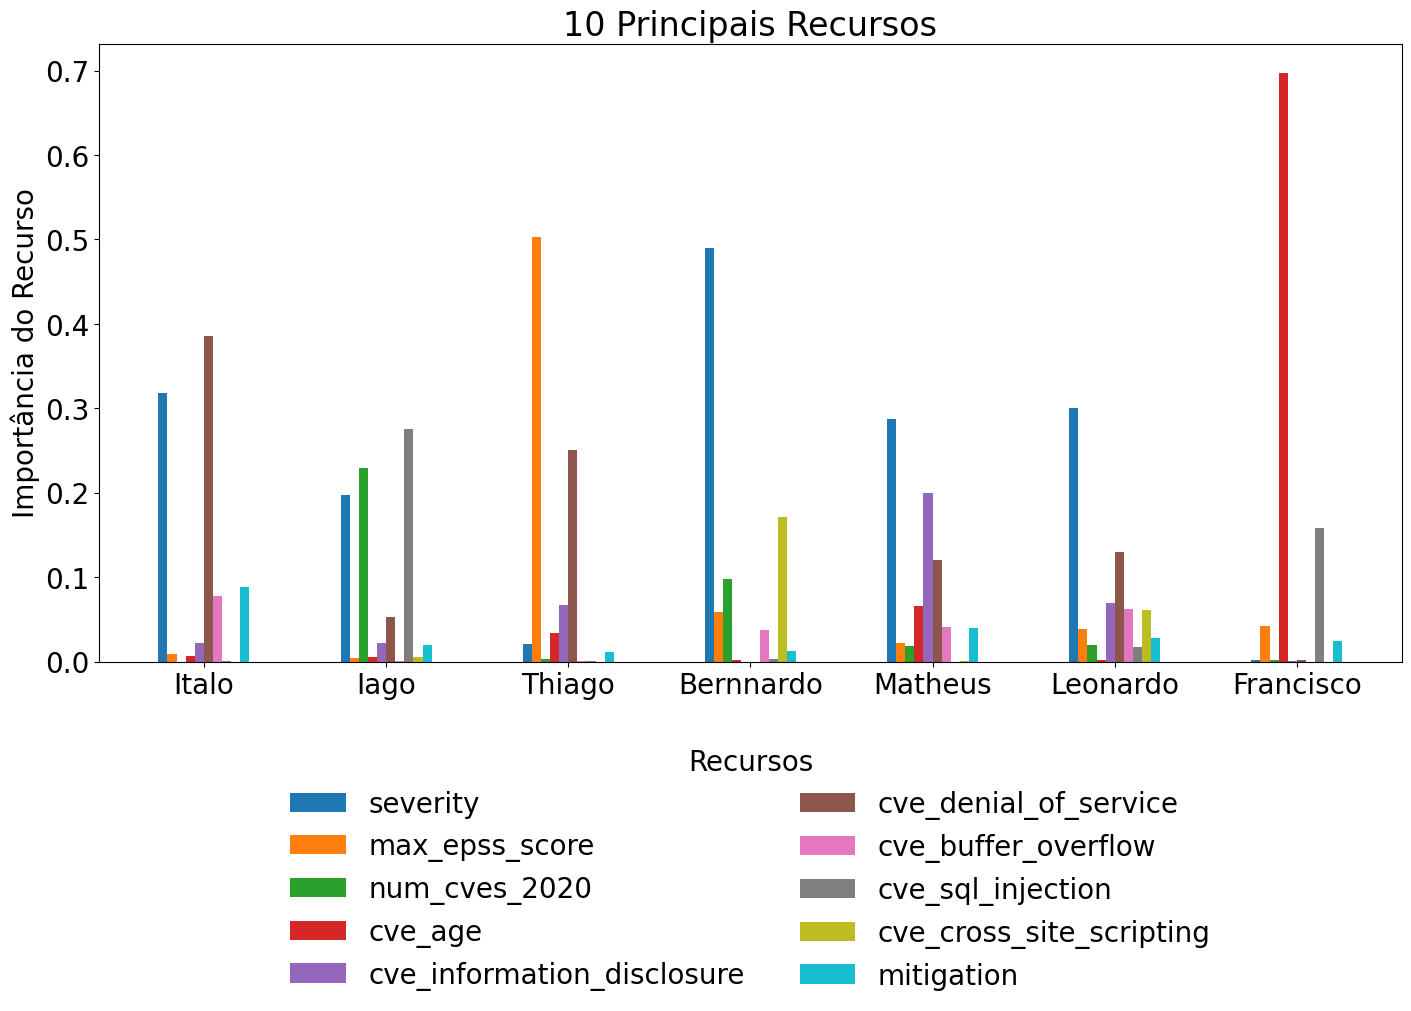

In [8]:
feature_importance = {key : 0 for key in train_X.columns}
for user in class_users_real_name:
    model = user2model[user]
    for i, j in zip(feature_names, model.feature_importances_):
        feature_importance[i] += j
top10_feature_importance = sorted(feature_importance, key=feature_importance.get, reverse=True)[:10]

top10_user_feature = {}
for user in class_users_real_name:
    model = user2model[user]
    user_df = class_df[class_df["email"] == user]
    top10_user_feature[rename_users_class[user]] = {item[0] : item[1] for item in zip(feature_names, model.feature_importances_) if item[0] in top10_feature_importance}

df_top10_feature = pd.DataFrame.from_dict(top10_user_feature, orient='index')

graphics = model_graphics.Graphics()
if english:
    title = '10 Most Important Features'
    output_name = 'groupedbar_10features_en'
    y_label = 'Feature Importance'
    legend_title = 'Features'
else:
    title = '10 Principais Recursos'
    output_name = 'groupedbar_10features_pt'
    y_label = 'Importância do Recurso'
    legend_title = 'Recursos'

graphics.groupedbar(df_top10_feature, output_name, title, y_label, legend_title=legend_title, ncol=2)

### Making Predictions for Each User’s Own Votes
After training the personalized models, we use them to predict the ranking values for each user's own voting data.

For each user, we retrieve the corresponding data and remove unused columns. If a user has no associated votes, we skip them and store empty prediction results.

Predictions are generated using the user’s trained model, and we store both the predicted ranking and whether the vote was within the “in_kev” subset. True ranking values are also saved for later comparison or evaluation.

In [9]:
for user in class_users_real_name:
    model = user2model[user]
    user_rows = class_df[class_df["email"] == user]

    if user_rows.empty:
        print(f"[AVISO] Usuário {user} não possui votos.")
        user2predictions[user] = []
        user2truevotes[user] = []
        continue

    test_X = user_rows.drop(columns=["ranking", "email", "user_id", "fid", "id"])
    predictions = model.predict(test_X)

    user2in_kev[user] = test_X["in_kev"].astype(bool).tolist()
    user2predictions[user] = list(zip(predictions, user2in_kev[user]))
    user2truevotes[user] = user_rows["ranking"].to_numpy()

### Visualizing Predicted vs. Actual Risk for Each User
For each user, we generate scatter plots comparing predicted and actual risk rankings. Predictions are separated based on whether the finding is in the KEV dataset. A linear trend line and a perfect prediction reference line are included to assess model performance. The plots are saved individually for each user.

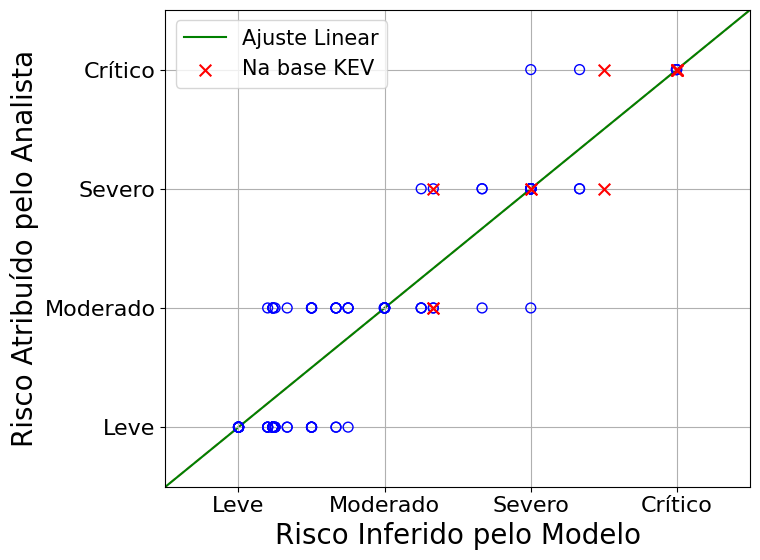

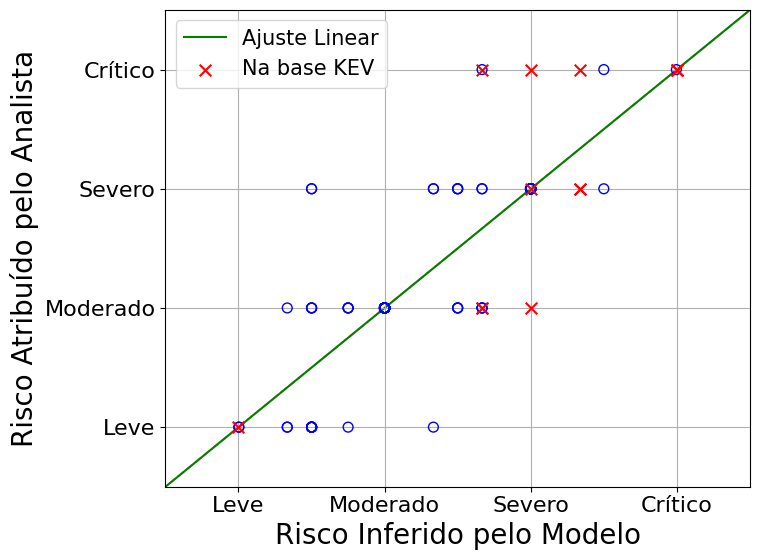

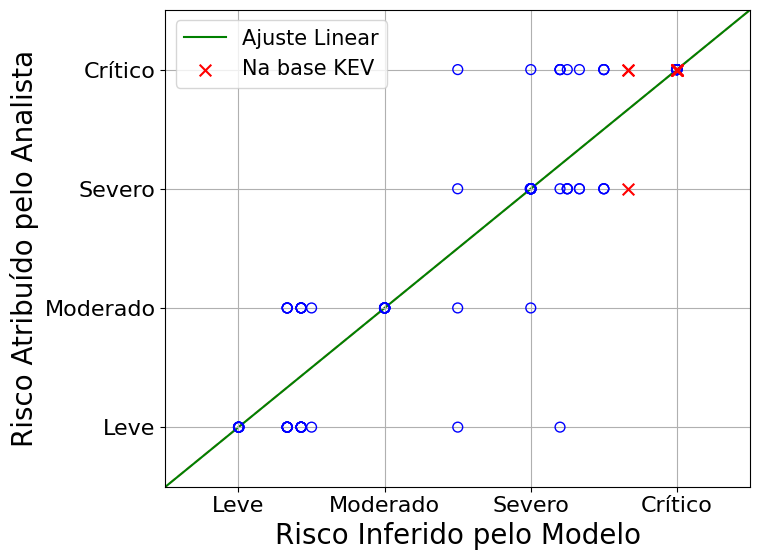

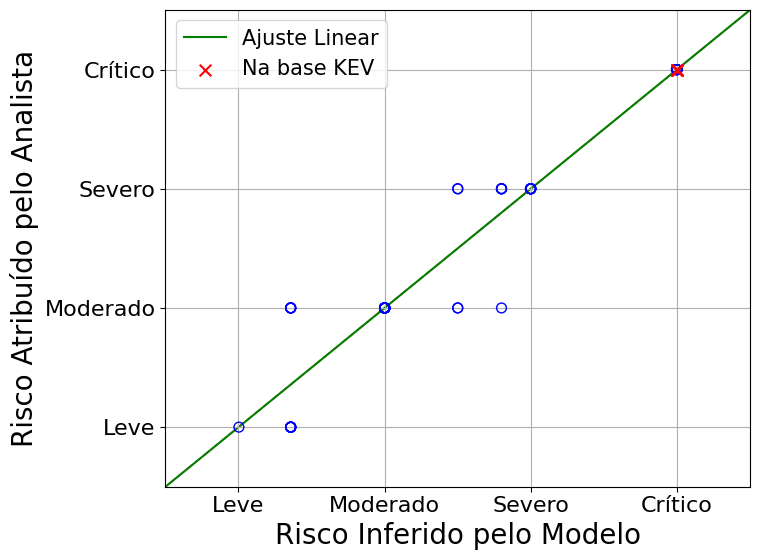

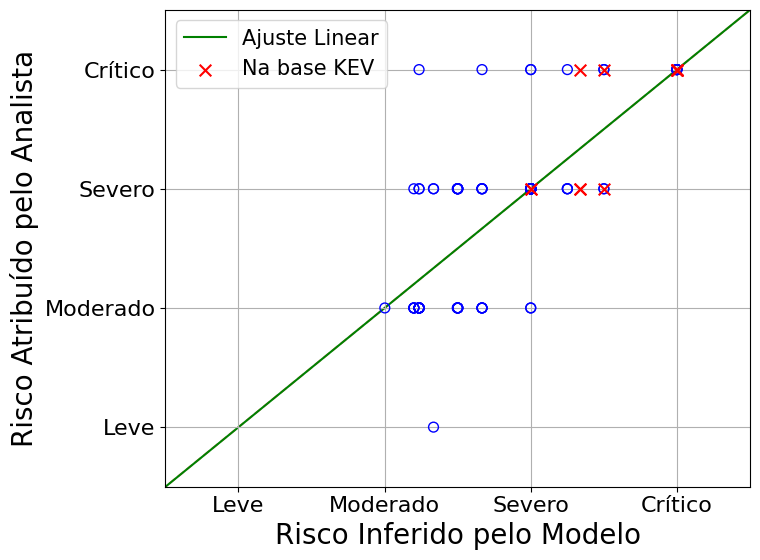

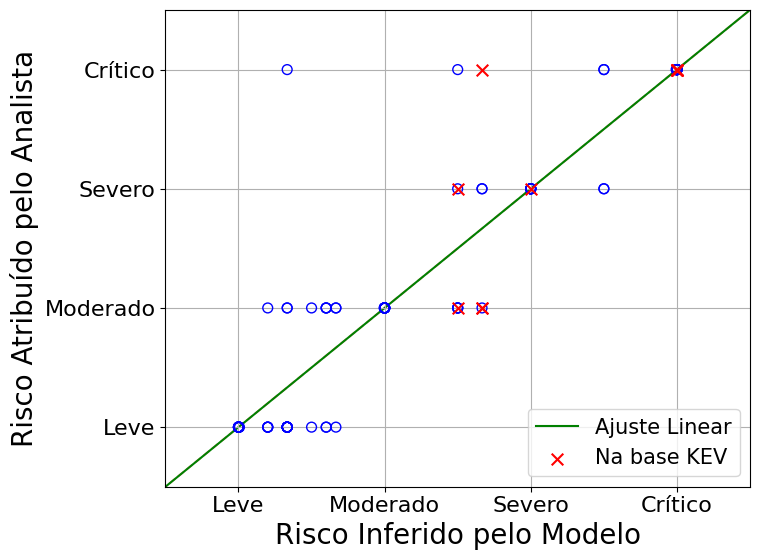

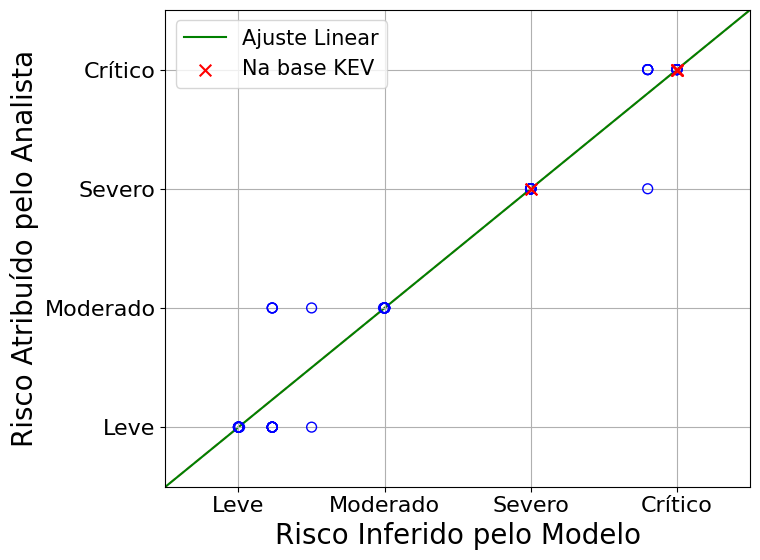

In [ ]:
if english:
    severity_labels = ["Low", "Medium", "High", "Critical"]
else:
    severity_labels = ["Leve", "Moderado", "Severo", "Crítico"]
severity_ticks = [1, 2, 3, 4]

output_dir = os.path.join(current_dir, 'model_graphics')
os.makedirs(output_dir, exist_ok=True)

for user in class_users_real_name:
    pred_tuples = user2predictions[user]
    true_votes = user2truevotes[user]

    # Separate the data according to kev=True or False
    pred_kev_true = []
    true_kev_true = []
    pred_kev_false = []
    true_kev_false = []

    for (pred, kev), true_vote in zip(pred_tuples, true_votes):
        if kev:
            pred_kev_true.append(pred)
            true_kev_true.append(true_vote)
        else:
            pred_kev_false.append(pred)
            true_kev_false.append(true_vote)

    plt.figure(figsize=(8, 6))

    # lines of best fit (using all data)
    all_pred = [p for p, _ in pred_tuples]
    slope, intercept, *_ = linregress(all_pred, true_votes)
    if english:
        plt.plot([0, 5], [intercept, (5 * slope) + intercept], color='green', linestyle='-', label='Linear Fit', zorder=1)
    else:
        plt.plot([0, 5], [intercept, (5 * slope) + intercept], color='green', linestyle='-', label='Ajuste Linear', zorder=1)

    # Line of perfect prediction
    plt.plot([0, 20], [0, 20], color='#ff9999', linestyle='--', zorder=0)

    # Scatter differentiated
    plt.scatter(pred_kev_false, true_kev_false, color='blue', alpha=1, s=50, zorder=2, marker='o', facecolors='none')
    if english:
        plt.scatter(pred_kev_true, true_kev_true, color='red', alpha=1, s=70, label='In KEV Base', zorder=3, marker='x')
    else:
        plt.scatter(pred_kev_true, true_kev_true, color='red', alpha=1, s=70, label='Na base KEV', zorder=3, marker='x')

    user_label = rename_users_class.get(user, user)
    if english:
        plt.xlabel('Inferred Risk by Model', fontsize=20)
        plt.ylabel('Risk Assigned by Analyst', fontsize=20)
    else:
        plt.xlabel('Risco Inferido pelo Modelo', fontsize=20)
        plt.ylabel('Risco Atribuído pelo Analista', fontsize=20)
    plt.grid()
    plt.legend(fontsize=15)

    # Limits and categorical ticks
    plt.xlim(0.5, 4.5)
    plt.ylim(0.5, 4.5)
    plt.xticks(severity_ticks, severity_labels, fontsize=16)
    plt.yticks(severity_ticks, severity_labels, fontsize=16)

    output_path = os.path.join(output_dir, f'scatter_votepredictions_{user_label}.pdf')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()

